# Bedrock Agents with Code Interpreter

In this notebook, we show how to create a Bedrock Agent with Code Interpreter. `langchain-aws` library provides a BedrockAgentsRunnable which can be used with LangChain's AgentExecutor.

### Prerequisites:
1. Set your aws credentials for your environment, example: https://docs.aws.amazon.com/cli/v1/userguide/cli-configure-envvars.html#envvars-set.
1. Ensure that langchain, langgraph are installed in the environment and that the local langchain-aws is accessible from the path or installed into the environment. 

## Example 1: Create a financial analyst agent.
In this example, we create a financial analyst with a code interpreter.

### Step 1: Define a tool for retrieving data.

In [1]:
from langchain_core.tools import tool
import json

my_stock_data = [
  {
    "date": "2025-02-13",
    "open": 6060.59,
    "high": 6116.91,
    "low": 6050.95,
    "close": 6115.07
  },
  {
    "date": "2025-02-12",
    "open": 6025.08,
    "high": 6063.00,
    "low": 6003.00,
    "close": 6051.97
  },
  {
    "date": "2025-02-11",
    "open": 6049.32,
    "high": 6076.28,
    "low": 6042.34,
    "close": 6068.50
  },
  {
    "date": "2025-02-10",
    "open": 6046.40,
    "high": 6073.38,
    "low": 6044.84,
    "close": 6066.44
  },
  {
    "date": "2025-02-07",
    "open": 6083.13,
    "high": 6101.28,
    "low": 6019.96,
    "close": 6025.99
  },
  {
    "date": "2025-02-06",
    "open": 6072.22,
    "high": 6084.03,
    "low": 6046.83,
    "close": 6083.57
  },
  {
    "date": "2025-02-05",
    "open": 6020.45,
    "high": 6062.86,
    "low": 6007.06,
    "close": 6061.48
  },
  {
    "date": "2025-02-04",
    "open": 5998.14,
    "high": 6042.48,
    "low": 5990.87,
    "close": 6037.88
  },
  {
    "date": "2025-02-03",
    "open": 5969.65,
    "high": 6022.13,
    "low": 5923.93,
    "close": 5994.57
  },
  {
    "date": "2025-01-31",
    "open": 6096.79,
    "high": 6120.91,
    "low": 6030.93,
    "close": 6040.53
  },
  {
    "date": "2025-01-30",
    "open": 6050.75,
    "high": 6086.64,
    "low": 6027.46,
    "close": 6071.17
  },
  {
    "date": "2025-01-29",
    "open": 6057.70,
    "high": 6062.83,
    "low": 6012.96,
    "close": 6039.31
  }
]

@tool("stock_data::get_stock_prices")
def get_stock_prices(stock_symbol: str) -> str:
    """
        Gets the prices series of symbol, date, open, high, low, close.

        Args:
            stock_symbol: The stock symbol to query data for.

        Returns:
            A json price series serialized as a string.
    
    """
    return json.dumps(my_stock_data, indent=2)


tools = [get_stock_prices]
tools

/Users/bakjohn/PycharmProjects/langchain-aws/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[StructuredTool(name='stock_data::get_stock_prices', description='Gets the prices series of symbol, date, open, high, low, close.\n\nArgs:\n    stock_symbol: The stock symbol to query data for.\n\nReturns:\n    A json price series serialized as a string.', args_schema=<class 'langchain_core.utils.pydantic.stock_data::get_stock_prices'>, func=<function get_stock_prices at 0x106d17d30>)]

### Step 2: Define the foundation model and instructions for the agent

In [2]:
foundational_model = 'anthropic.claude-3-sonnet-20240229-v1:0'
foundational_model

'anthropic.claude-3-sonnet-20240229-v1:0'

In [3]:
instructions="You are an agent who answers financial questions."
instructions

'You are an agent who answers financial questions.'

### Step 3: Define the resource role to use with the Bedrock Agent

In [4]:
import boto3
import json
import time
import uuid

def _create_agent_role(
        agent_region,
        foundational_model
) -> str:
    """
    Create agent resource role prior to creation of agent, at this point we do not have agentId, keep it as wildcard

    Args:
        agent_region: AWS region in which is the Agent if available
        foundational_model: The model used for inference in AWS BedrockAgents
    Returns:
       Agent execution role arn
    """
    try:
        account_id = boto3.client('sts').get_caller_identity().get('Account')
        assume_role_policy_document = json.dumps({
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {
                        "Service": "bedrock.amazonaws.com"
                    },
                    "Action": "sts:AssumeRole",
                    "Condition": {
                        "ArnLike": {
                            "aws:SourceArn": f"arn:aws:bedrock:{agent_region}:{account_id}:agent/*"
                        }
                    }
                }
            ]
        })
        managed_policy = {
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Sid": "AmazonBedrockAgentBedrockFoundationModelStatement",
                    "Effect": "Allow",
                    "Action": "bedrock:InvokeModel",
                    "Resource": [
                        f"arn:aws:bedrock:{agent_region}::foundation-model/{foundational_model}"
                    ]
                }
            ]
        }
        role_name = f'bedrock_agent_{uuid.uuid4()}'
        iam_client = boto3.client('iam')
        response = iam_client.create_role(
            RoleName=role_name,
            AssumeRolePolicyDocument=assume_role_policy_document,
            Description='Role for Bedrock Agent'
        )
        iam_client.put_role_policy(
            RoleName=role_name,
            PolicyName=f'AmazonBedrockAgentBedrockFoundationModelPolicy_{uuid.uuid4()}',
            PolicyDocument=json.dumps(managed_policy)
        )
        time.sleep(2)
        return response.get('Role', {}).get('Arn', '')

    except Exception as exception:
        raise exception

agent_resource_role_arn = _create_agent_role(
            agent_region='us-west-2',
            foundational_model=foundational_model)

agent_resource_role_arn

'arn:aws:iam::151065682055:role/bedrock_agent_b382102d-a9f5-4194-bc5e-e788330340d8'

### Step 4: Now create the Bedrock Agent and initialize the AgentExecutor

In [5]:
from langchain.agents import AgentExecutor
from langchain_aws.agents import BedrockAgentsRunnable

#setting enable trace to True, if you do not want all the trace events then set to False.
my_enable_trace = True

agent = BedrockAgentsRunnable.create_agent(
            agent_name="financial_analyst_agent",
            agent_resource_role_arn=agent_resource_role_arn,
            foundation_model=foundational_model,
            instruction="""
            You are an agent who helps with getting answers to financial questions using stock data""",
            tools=tools,
            enable_trace=my_enable_trace,
            enable_code_interpreter=True
        )

agent_executor = AgentExecutor(agent=agent, tools=tools, return_intermediate_steps=True) 
agent_executor


/Users/bakjohn/PycharmProjects/langchain-aws/venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_arn" in BedrockRerank has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


AgentExecutor(verbose=False, agent=RunnableAgent(runnable=BedrockAgentsRunnable(agent_id='543RIBXFCF', client=<botocore.client.AgentsforBedrockRuntime object at 0x10f28c700>, enable_trace=True), input_keys_arg=[], return_keys_arg=[], stream_runnable=True), tools=[StructuredTool(name='stock_data::get_stock_prices', description='Gets the prices series of symbol, date, open, high, low, close.\n\nArgs:\n    stock_symbol: The stock symbol to query data for.\n\nReturns:\n    A json price series serialized as a string.', args_schema=<class 'langchain_core.utils.pydantic.stock_data::get_stock_prices'>, func=<function get_stock_prices at 0x106d17d30>)], return_intermediate_steps=True)

### Step 5: Invoke the agent

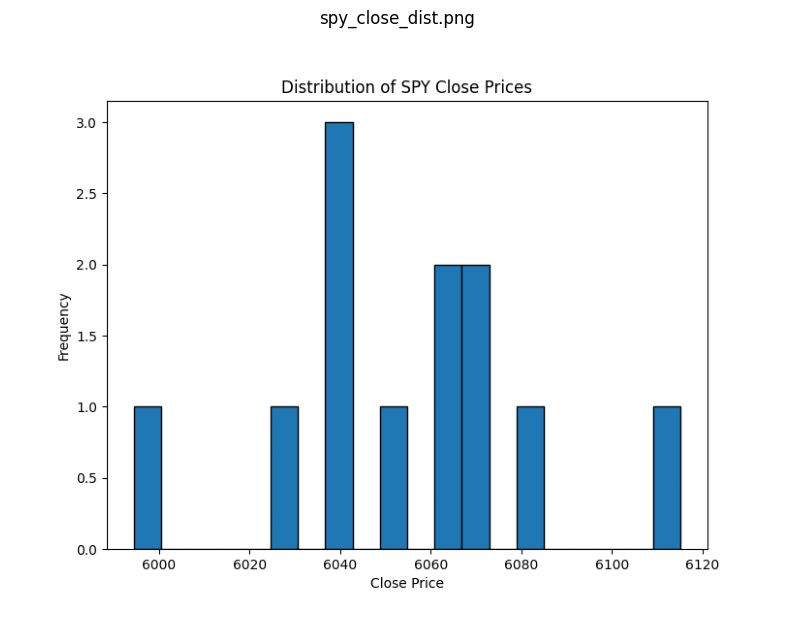

The distribution of SPY close prices is shown in the generated histogram plot. The plot displays the frequency of different close price values, allowing us to visualize the spread and concentration of the close prices over the given time period.


In [6]:
import matplotlib.pyplot as plt
import io

response = agent_executor.invoke({"input": "Plot the distribution of the SPY close prices"})

if "files" in response:
    for i, file in enumerate(response["files"]):
        name = file['name']
        type = file['type']
        bytes_data = file['bytes']
        if type == 'image/png':
            # Display PNG image using Matplotlib
            img = plt.imread(io.BytesIO(bytes_data))
            plt.figure(figsize=(10, 10))
            plt.imshow(img)
            plt.axis('off')
            plt.title(name)
            plt.show()
            plt.close()
    print(response["output"])
else:
    print(response)




#### Commentary
Since we specified `return_intermediate_steps=True`, we get the intermediate steps from the agents. The first time agent is invoked, it return a `BedrockAgentAction` to determine the asset value for the given asset holder. After the asset value is determined, the agent again return the control for the next tool with asset value and asset holder id to determine the interest rate. Once the interest rate is returned, the agent returns the final output `The mortgage rate for the asset holder ID AVC-1234 with an asset value of 100K is 8.87%.`

### Step 6: Cleanup

In [7]:
def delete_agent_role(agent_resource_role_arn: str):
    """
    Delete agent resource role

    Args:
       agent_resource_role_arn: Associated Agent execution role arn
    """
    try:
        iam_client = boto3.client('iam')
        role_name = agent_resource_role_arn.split('/')[-1]
        inline_policies = iam_client.list_role_policies(RoleName=role_name)
        for inline_policy_name in inline_policies.get('PolicyNames', []):
            iam_client.delete_role_policy(
                RoleName=role_name,
                PolicyName=inline_policy_name
            )
        iam_client.delete_role(
            RoleName=role_name
        )
    except Exception as exception:
        raise exception


def delete_agent(agent_id):
    bedrock_client = boto3.client('bedrock-agent')
    bedrock_client.delete_agent(agentId=agent_id, skipResourceInUseCheck=True)


delete_agent(agent_id=agent.agent_id)
delete_agent_role(agent_resource_role_arn=agent_resource_role_arn)